In [1]:
#Import libraries
import glob,os
import matplotlib.pyplot as plt
import cv2
import shutil  
import numpy as np
from scipy.optimize import curve_fit
import natsort
from numpy import arange, array, arctan,pi, median

In [2]:
#Answer This Question
HowManyFramesPerSecond=120
#What is the file address 
ad=r"C:\Users\shumalys\Python\ML\Chirag\Forward"
#What is the file name
vidcap = cv2.VideoCapture(ad+"\\"+'5 pass.avi')

In [3]:
#Adjust Image Size (just for plotting)
plt.rcParams["figure.figsize"] = (15,10)

In [4]:
#Import updateXY Function
def updateXY(Xpoint,Ypoint,Direction,i):
    if Direction=='Up':
        xl=int(Xpoint)
        yl=int(Ypoint)-i
    if Direction=='UR':
        xl=int(Xpoint)+i
        yl=int(Ypoint)-i
    if Direction=='Right':
        xl=int(Xpoint)+i
        yl=int(Ypoint)
    if Direction=='DR':
        xl=int(Xpoint)+i
        yl=int(Ypoint)+i
    if Direction=='Down':
        xl=int(Xpoint)
        yl=int(Ypoint)+i
    if Direction=='DL':
        xl=int(Xpoint)-i
        yl=int(Ypoint)+i
    if Direction=='Left':
        xl=int(Xpoint)-i
        yl=int(Ypoint)
    if Direction=='UL':
        xl=int(Xpoint)-i
        yl=int(Ypoint)-i
    return(xl,yl)
#Import IncreaseRes2 Function
def IncreaseRes2(Image,Xpoint,Ypoint,IR_Thr,Direction):
    X_next=[]
    Y_next=[]
    Reasons=[]
    #Move and gather values
    XL_next=[]
    YL_next=[]
    Value_next=[]
    ThereIsNoAnswer=0
    for i in range(10):
        #Moving direction
        xl,yl=updateXY(Xpoint,Ypoint,Direction,i)
        #Making cordinations and values series
        XL_next=XL_next+[xl]
        YL_next=YL_next+[yl]
        try:
            Image[int(yl),int(xl)]
        except:
            ThereIsNoAnswer=1
            Reasons=Reasons+['DimentionError']
            break
        Value_next=Value_next+[Image[int(yl),int(xl)]]
        #Break If there is zero
        if Image[int(yl),int(xl)]==0:
            ThereIsNoAnswer=1
            Reasons=Reasons+['ZeroNum']
            break
        #Break if the value is decreasing   
        if len(Value_next) >1:
            if Value_next[-2]>=Value_next[-1]:
                ThereIsNoAnswer=1
                Reasons=Reasons+['Decreasing']
                break
        #Break if is more than the Threshold
        if Image[int(yl),int(xl)]>=IR_Thr:  
            if len(Value_next)==1:
                #Exception: No answer if direction has Zero
                xl,yl=updateXY(Xpoint,Ypoint,Direction,i+1)
                if Image[int(yl),int(xl)]==0:
                    ThereIsNoAnswer=1
                    Reasons=Reasons+['ZeroNum, wrong direction']
                    break
                if Value_next>Image[int(yl),int(xl)]:
                    ThereIsNoAnswer=1
                    Reasons=Reasons+['Decreasing, wrong direction']
                    break          
            Reasons=Reasons+['OK']
            break
    #Convert Value Matrix to differential value matrix 
    Converted_Value_next=Value_next.copy()
    if ThereIsNoAnswer==0:
        if len(Value_next)==1:
            Converted_Value_next[0]=IR_Thr
        if len(Value_next)>1:
            for i in range(len(Value_next)-1):
                if Converted_Value_next[i+1]>IR_Thr:
                    Converted_Value_next[i+1]=IR_Thr-Value_next[i]
                    break
                Converted_Value_next[i+1]=Value_next[i+1]-Value_next[i]
    if ThereIsNoAnswer==0:
        Cumulative_Value=[] 
        for i in range(len(Converted_Value_next)):        
            Cumulative_Value=Cumulative_Value+[XL_next[i]*Converted_Value_next[i]]
        X_next=X_next+[np.array(Cumulative_Value).sum()/IR_Thr]
        Cumulative_Value=[] 
        for i in range(len(Converted_Value_next)):
            Cumulative_Value=Cumulative_Value+[YL_next[i]*Converted_Value_next[i]]
        Y_next=Y_next+[np.array(Cumulative_Value).sum()/IR_Thr]
    if ThereIsNoAnswer==1:
        X_next=X_next+[0]
        Y_next=Y_next+[0]
        ThereIsNoAnswer=0
    return(X_next, Y_next, Reasons)
#Line equation
def objective(x, a, b):
    return a *x + b        

In [5]:
#After converting video to frames, delete frames that droplet is moving to left side. 
#because just right side movement is calculable. in this case i deleted 0 to 81 frames and just remained 82 to 459

In [6]:
#Convert Video to Frames
#For chirag: if you did it once, please skip this cell for next time
SelectingRate=1
success,image = vidcap.read()
count=-1
Num=0
NewFolder=ad+"\\"+"Frames"
try:
    os.makedirs(NewFolder)
except:
    shutil.rmtree(NewFolder)
    os.makedirs(NewFolder)
NewFolder=ad+"\\"+"Frames"
print('Frame Selecting+++++++++++++++++++++++++++++++++++++++++++++++++',end='\n')
while True:
    count += 1
    success,image = vidcap.read()
    if count%SelectingRate!=0:
        continue
    try:
        Num+=1
        print(Num,':',count,end=' __ ')
        image=cv2.flip(image,1)
        cv2.imwrite(NewFolder+"\\"+"%d.tiff" % count, image)
    except:
        break

Frame Selecting+++++++++++++++++++++++++++++++++++++++++++++++++
1 : 0 __ 2 : 1 __ 3 : 2 __ 4 : 3 __ 5 : 4 __ 6 : 5 __ 7 : 6 __ 8 : 7 __ 9 : 8 __ 10 : 9 __ 11 : 10 __ 12 : 11 __ 13 : 12 __ 14 : 13 __ 15 : 14 __ 16 : 15 __ 17 : 16 __ 18 : 17 __ 19 : 18 __ 20 : 19 __ 21 : 20 __ 22 : 21 __ 23 : 22 __ 24 : 23 __ 25 : 24 __ 26 : 25 __ 27 : 26 __ 28 : 27 __ 29 : 28 __ 30 : 29 __ 31 : 30 __ 32 : 31 __ 33 : 32 __ 34 : 33 __ 35 : 34 __ 36 : 35 __ 37 : 36 __ 38 : 37 __ 39 : 38 __ 40 : 39 __ 41 : 40 __ 42 : 41 __ 43 : 42 __ 44 : 43 __ 45 : 44 __ 46 : 45 __ 47 : 46 __ 48 : 47 __ 49 : 48 __ 50 : 49 __ 51 : 50 __ 52 : 51 __ 53 : 52 __ 54 : 53 __ 55 : 54 __ 56 : 55 __ 57 : 56 __ 58 : 57 __ 59 : 58 __ 60 : 59 __ 61 : 60 __ 62 : 61 __ 63 : 62 __ 64 : 63 __ 65 : 64 __ 66 : 65 __ 67 : 66 __ 68 : 67 __ 69 : 68 __ 70 : 69 __ 71 : 70 __ 72 : 71 __ 73 : 72 __ 74 : 73 __ 75 : 74 __ 76 : 75 __ 77 : 76 __ 78 : 77 __ 79 : 78 __ 80 : 79 __ 81 : 80 __ 82 : 81 __ 83 : 82 __ 84 : 83 __ 85 : 84 __ 86 : 85 __ 87 : 86 

In [24]:
#Calculate for every frame
NewFolder=ad+"\\"+"Frames"
DetectedImages=ad+"\\"+"DetectedImages"
try:
    os.makedirs(DetectedImages)
except:
    shutil.rmtree(DetectedImages)
    os.makedirs(DetectedImages)  
FileName=sorted(os.listdir(NewFolder))
FileNames=[]
for i in range(len(FileName)):
    try:
        if FileName[i].split(".")[1]=="tiff":
            FileNames=FileNames+[FileName[i]]
    except:
        pass
fps=HowManyFramesPerSecond
FileNames=natsort.natsorted(FileNames)
RDEGREE=[]
ADEGREE=[]
RDEGREEP=[]
ADEGREEP=[]
RDEGREEV=[]
ADEGREEV=[]
file_number=[]
for FileName in FileNames:
    print(FileName,end='_')
    Img=cv2.imread(NewFolder+"\\"+FileName)
    
    #Morphological transformation
    kernel = np.ones((6,6),np.uint8) #3 is maximum allowed number
    Img=cv2.morphologyEx(np.array(Img), cv2.MORPH_CLOSE, kernel)
    Img=cv2.morphologyEx(np.array(Img), cv2.MORPH_OPEN, kernel)
    
    BaseLine=495
    
    HorizontalStartPoint=0
    HorizontalEndPoint=700
    Img_BW=Img[:,:,0]
    Img_WB=255-Img_BW
    # Crop Image
    CroppedIMg=Img_WB[BaseLine:BaseLine+300,HorizontalStartPoint:HorizontalEndPoint]
    CroppedIMg2=Img[BaseLine:BaseLine+300,HorizontalStartPoint:HorizontalEndPoint]
    # Threshold for skipping noises, Y length: how many pixels are needed?
    Thr=120   # 80-120, you can increase it to ignore noises
    YLength=20
    # Find Advancing and Receding Pixels
    X=[]
    Y=[]
    for y in np.arange(CroppedIMg.shape[0]-YLength,CroppedIMg.shape[0]):
        for x in range(CroppedIMg.shape[1]):
             if CroppedIMg[y,x] > Thr:
                CroppedIMg2[y,x,:]=[255,0,0]
                X=X+[x]
                Y=Y+[y]
                break
    Xl=[]
    Yl=[]
    for y in np.arange(CroppedIMg.shape[0]-YLength,CroppedIMg.shape[0]):
        for x in np.arange(CroppedIMg.shape[1]-1,0,-1):
             if CroppedIMg[y,x] > Thr:
                CroppedIMg2[y,x,:]=[255,0,0]
                Xl=Xl+[x]
                Yl=Yl+[y]
                break
    #Increase Res 
    IR_Thr=250
    Dir='Right'
    X_updated=[]
    for x in range(len(X)):
        x_updated=IncreaseRes2(CroppedIMg,X[x],Y[x],IR_Thr,Dir)[0]
        X_updated=X_updated+x_updated
    Dir='Left'
    Xl_updated=[]
    for x in range(len(Xl)):
        x_updated=IncreaseRes2(CroppedIMg,Xl[x],Yl[x],IR_Thr,Dir)[0]
        Xl_updated=Xl_updated+x_updated
    popt, _ = curve_fit(objective, X_updated, max(Y)-np.array(Y))
    a, b = popt
    x_line = np.arange(min(X_updated), max(X_updated), .00001)
    y_line = objective(x_line, a, b)
    popt, _ = curve_fit(objective, Xl_updated, max(Yl)-np.array(Yl))
    a, b = popt
    xl_line = np.arange(min(Xl_updated), max(Xl_updated), .00001)
    yl_line = objective(xl_line, a, b)
       
    if len(x_line)!=0:
        dx=x_line[1]-x_line[0]
        dy=y_line[1]-y_line[0]
        gradian=arctan((dy)/(dx))
        if dy*dx<0:
            Rdegree=180+gradian*180/pi
        if dy*dx>0:
            Rdegree=gradian*180/pi
    else:
        Rdegree=90
        
    if len(xl_line)!=0: 
        dx=xl_line[1]-xl_line[0]
        dy=yl_line[1]-yl_line[0]
        gradian=arctan((dy)/(dx))
        if dx==0:
            Adegree=90
        if dy*dx<0:
            Adegree=-gradian*180/pi
        if dy*dx>0:
            Adegree=180-gradian*180/pi
    else:
        Adegree=90
        
        
    CI3=Img[BaseLine:BaseLine+300,HorizontalStartPoint:].copy()
    for x,y in zip(X_updated,Y):
        CI3[round(y),round(x)]=[0,255,0]
    for x,y in zip(Xl_updated,Yl):
        CI3[round(y),round(x)]=[255,0,0]
    
    xc1=np.mean(Xl_updated)
    yc1=np.mean(Yl)
    xc2=np.mean(X_updated)
    yc2=np.mean(Yl)
    CI3[round(yc1),round(xc1)]=[0,0,255]
    CI3[round(yc2),round(xc2)]=[255,255,255]
    cv2.imwrite(DetectedImages+'/image_'+FileName.split('.')[0]+'.tif',CI3)
    file_number.append(int(FileName.split('.')[0]))
    RDEGREE=RDEGREE+[Rdegree]
    ADEGREE=ADEGREE+[Adegree]
    
    RDEGREEP.append(np.mean(X_updated))
    ADEGREEP.append(np.mean(Xl_updated))
    
    
for i in range(len(RDEGREEP)-1):
    RDEGREEV.append(RDEGREEP[i+1]-RDEGREEP[i])
    ADEGREEV.append(ADEGREEP[i+1]-ADEGREEP[i])
RDEGREEV=np.array(RDEGREEV)*fps
ADEGREEV=np.array(ADEGREEV)*fps

52.tiff_53.tiff_54.tiff_55.tiff_56.tiff_57.tiff_58.tiff_59.tiff_60.tiff_61.tiff_62.tiff_63.tiff_64.tiff_65.tiff_66.tiff_67.tiff_68.tiff_69.tiff_70.tiff_71.tiff_72.tiff_73.tiff_74.tiff_75.tiff_76.tiff_77.tiff_78.tiff_79.tiff_80.tiff_81.tiff_82.tiff_83.tiff_84.tiff_85.tiff_86.tiff_87.tiff_88.tiff_89.tiff_90.tiff_91.tiff_92.tiff_93.tiff_94.tiff_95.tiff_96.tiff_97.tiff_98.tiff_99.tiff_100.tiff_101.tiff_102.tiff_103.tiff_104.tiff_105.tiff_106.tiff_107.tiff_108.tiff_109.tiff_110.tiff_111.tiff_112.tiff_113.tiff_114.tiff_115.tiff_116.tiff_117.tiff_118.tiff_119.tiff_120.tiff_121.tiff_122.tiff_123.tiff_124.tiff_125.tiff_126.tiff_127.tiff_128.tiff_129.tiff_130.tiff_131.tiff_132.tiff_133.tiff_134.tiff_135.tiff_136.tiff_137.tiff_138.tiff_139.tiff_140.tiff_141.tiff_142.tiff_143.tiff_144.tiff_145.tiff_146.tiff_147.tiff_148.tiff_149.tiff_150.tiff_151.tiff_152.tiff_153.tiff_154.tiff_155.tiff_156.tiff_157.tiff_158.tiff_159.tiff_160.tiff_161.tiff_162.tiff_163.tiff_164.tiff_165.tiff_166.tiff_167.tiff_168.

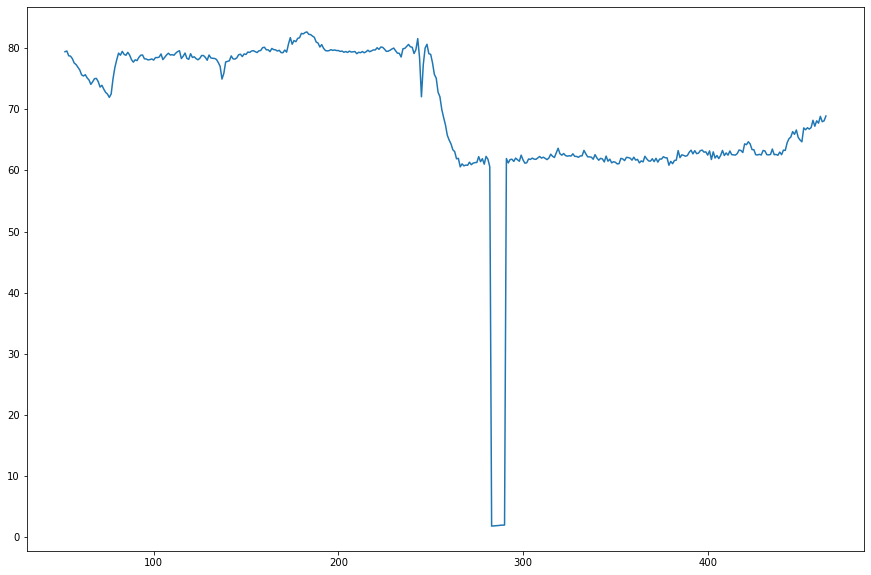

In [8]:
#Receding
plt.plot(file_number,RDEGREE)

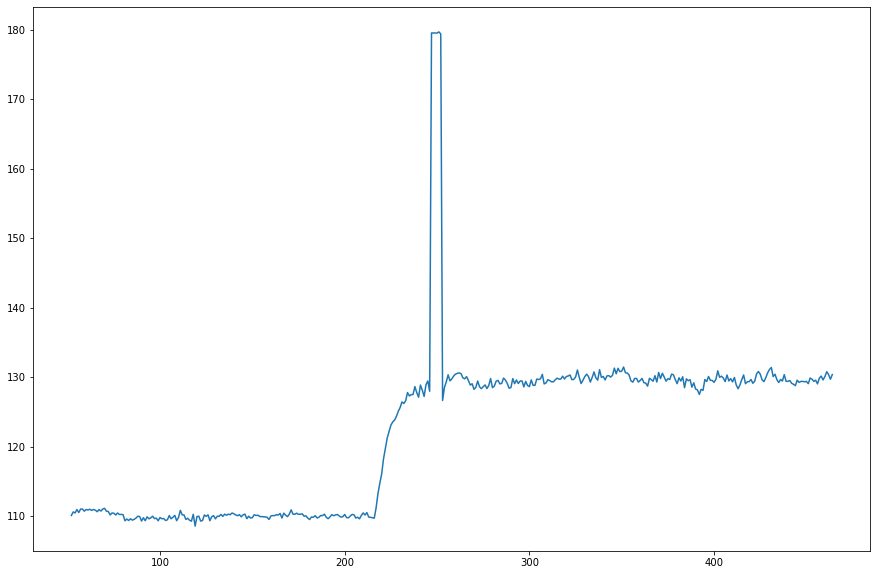

In [9]:
#Advancing
plt.plot(file_number,ADEGREE)

IndexError: index 410 is out of bounds for axis 0 with size 405

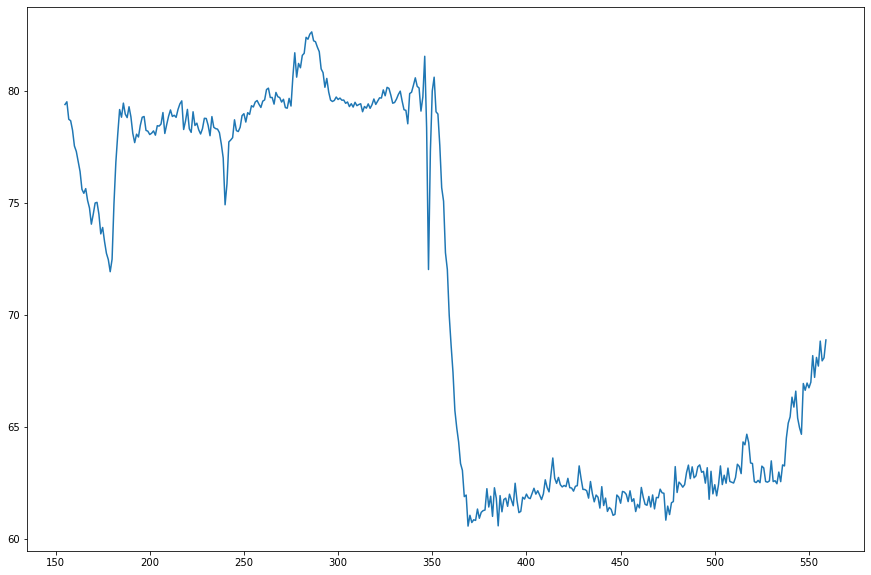

In [10]:
#Use this cell if you need to plot diagram with red dots
starting_number=155
Range=np.array([565,605,630,670,700])# red points


rec=np.array(RDEGREE)
rec=rec[(rec>15) & (rec<100)]
plt.plot(np.arange(starting_number,len(rec)+starting_number),rec)
Range=Range-starting_number
plt.plot(np.arange(starting_number,len(rec)+starting_number)[Range],rec[Range],'o',color='red')

In [ ]:
adv=np.array(ADEGREE)
adv=adv[(adv>30) & (adv<180)]
plt.plot(np.arange(starting_number,len(adv)+starting_number),adv)
plt.plot(np.arange(starting_number,len(adv)+starting_number)[Range],adv[Range],'.',color='red')

In [ ]:
#Average velocity of 20 receding Pixels
plt.plot(RDEGREEV[(RDEGREEV>-1500) & (RDEGREEV<1500)])

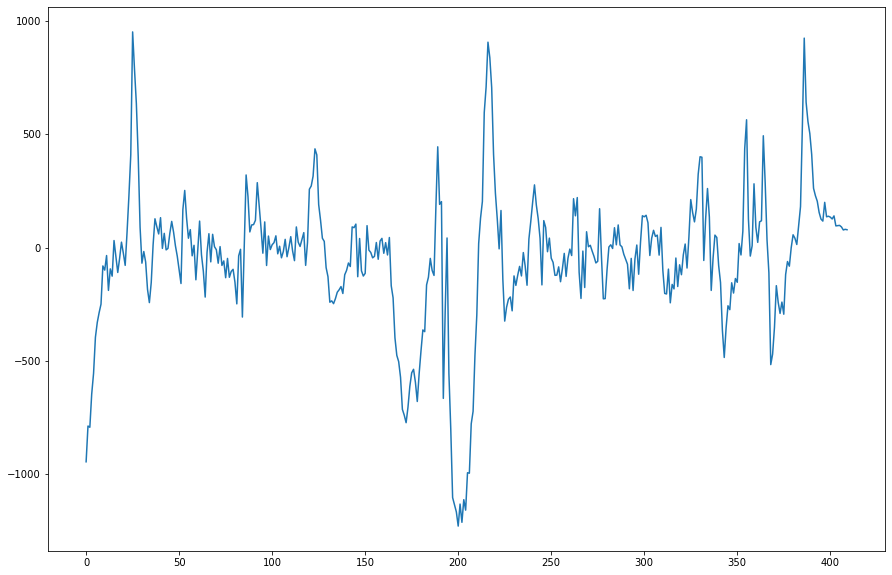

In [11]:
#Average position of 20 advancing pixels
plt.plot(ADEGREEV[(ADEGREEV>-1500) & (ADEGREEV<1500)])

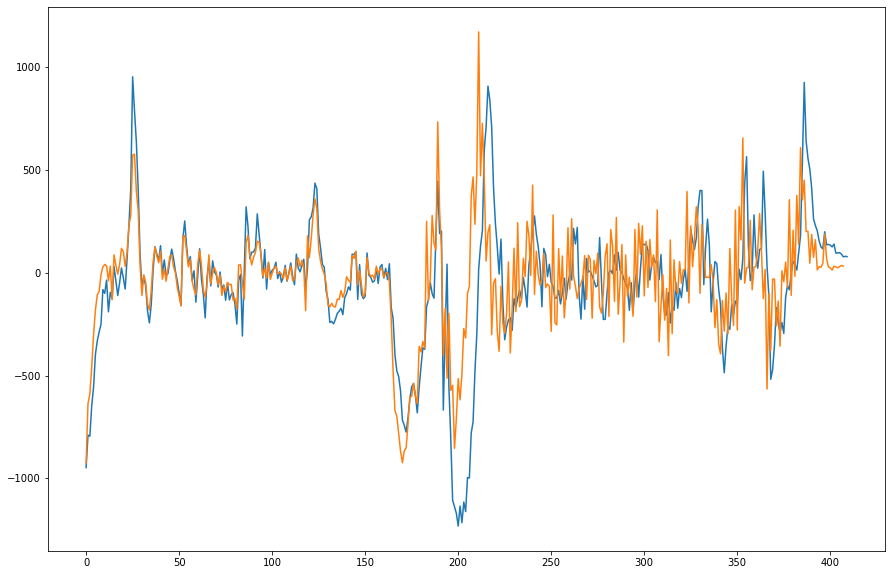

In [19]:
plt.plot(RDEGREEV[(RDEGREEV>-1500) & (RDEGREEV<1500)])
plt.plot(ADEGREEV[(ADEGREEV>-1500) & (ADEGREEV<1500)])

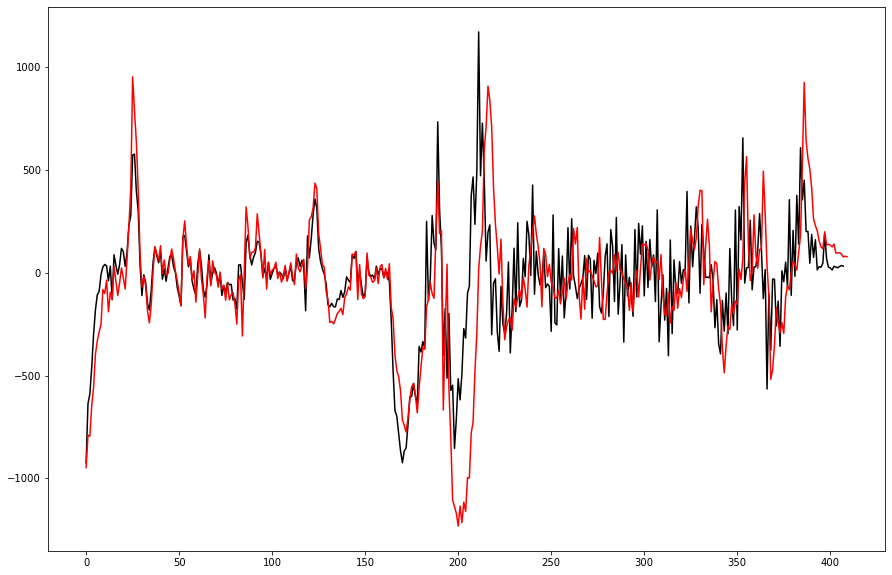

In [30]:

plt.plot(ADEGREEV[(ADEGREEV>-1500) & (ADEGREEV<1500)],color='black')
plt.plot(RDEGREEV[(RDEGREEV>-1500) & (RDEGREEV<1500)],color='red')

In [31]:
len(ADEGREEV)-len(ADEGREEV[(ADEGREEV>-1500) & (ADEGREEV<1500)])

4

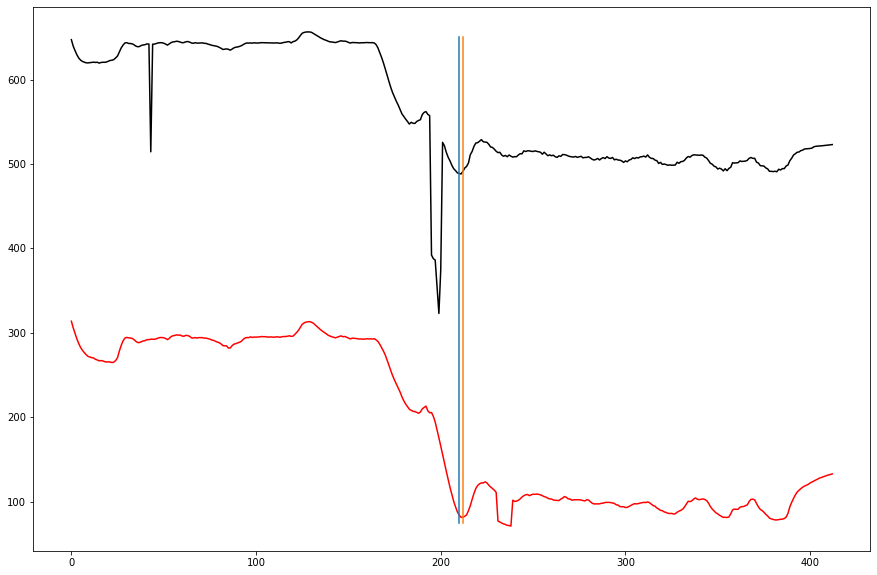

In [69]:
plt.plot(RDEGREEP,color='black')
plt.plot(ADEGREEP,color='red')
plt.plot([210,210],[75,650])
plt.plot([212,212],[75,650])


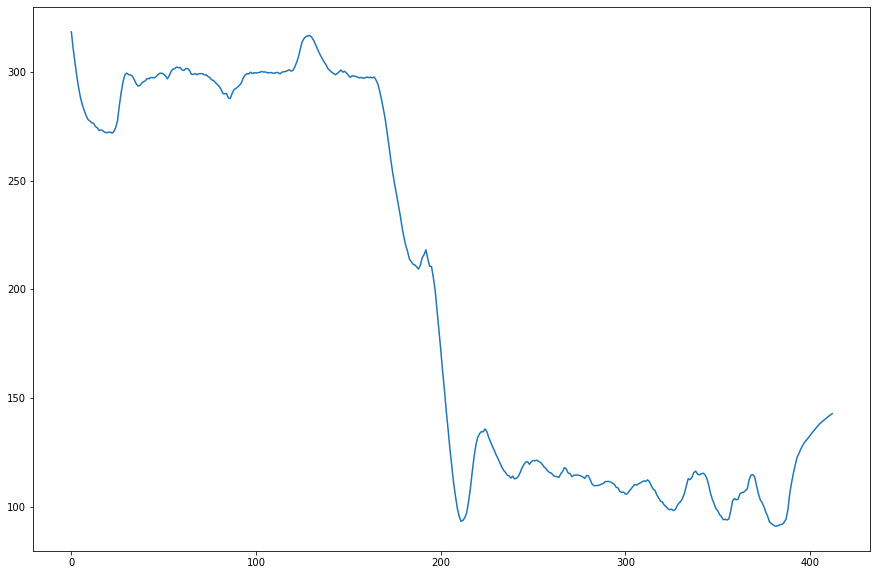

In [36]:
plt.plot(ADEGREEP)

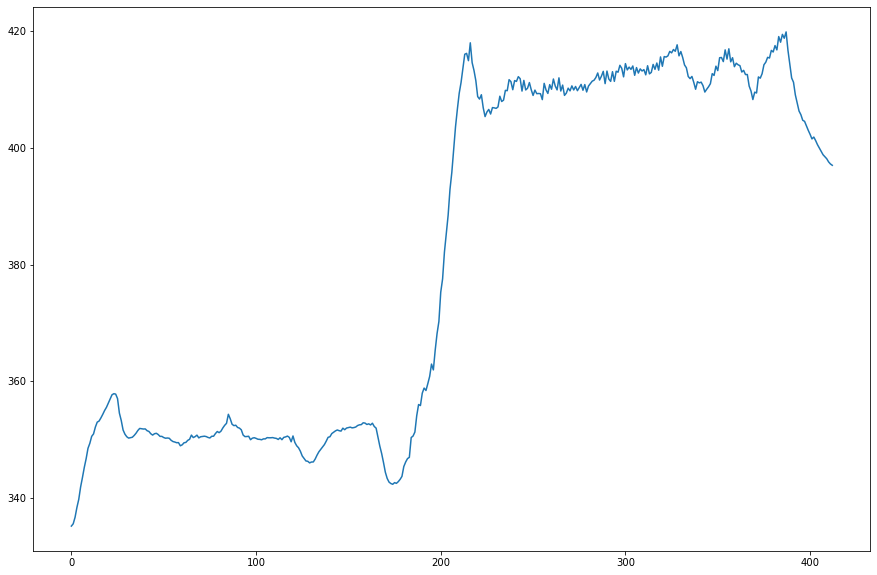

In [32]:
plt.plot(np.array(RDEGREEP)-np.array(ADEGREEP))

In [34]:
ADEGREEP

[318.5284,
 310.6438,
 304.293,
 297.76079999999996,
 292.5144000000001,
 288.02240000000006,
 284.81679999999994,
 282.2408,
 280.0058,
 278.196,
 277.5588,
 276.6922,
 276.46899999999994,
 275.02840000000003,
 274.39880000000005,
 273.14459999999997,
 273.4,
 273.0702,
 272.35439999999994,
 272.1032,
 272.35300000000007,
 272.4112,
 271.9514,
 272.593,
 274.55879999999996,
 277.68440000000004,
 284.8377999999999,
 290.7802,
 295.648,
 298.85679999999996,
 299.55539999999996,
 298.86560000000003,
 298.7214,
 298.20239999999995,
 296.662,
 294.77720000000005,
 293.6552,
 293.81000000000006,
 294.8316,
 295.5888,
 296.0180000000001,
 297.10119999999995,
 296.9668,
 297.54019999999997,
 297.43919999999997,
 297.408,
 298.0224,
 298.96419999999995,
 299.5251999999999,
 299.4764,
 299.0688,
 298.26160000000004,
 296.9288,
 298.37080000000003,
 300.32039999999995,
 301.3718,
 301.6786,
 302.3434,
 302.0758000000001,
 302.0914,
 300.95640000000003,
 300.81219999999996,
 301.6844,
 301.627,
 

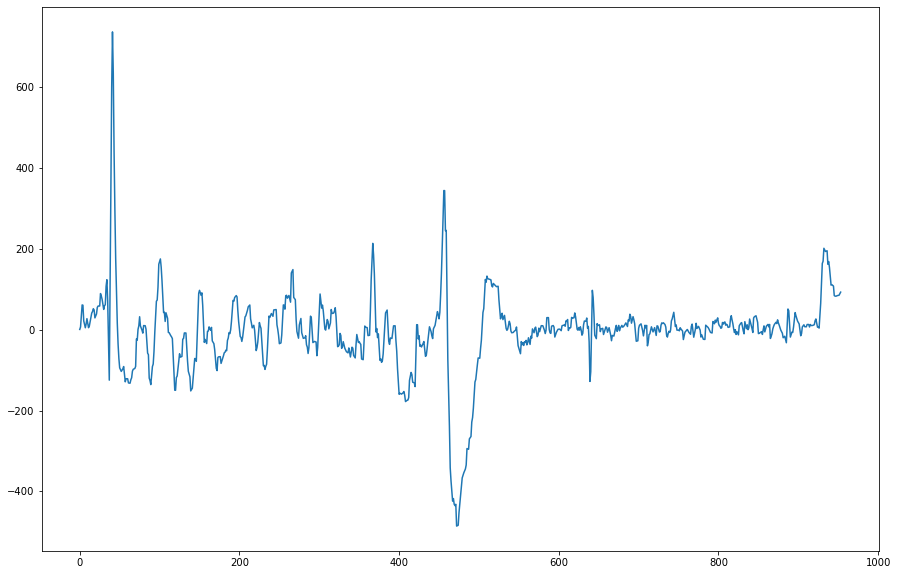

In [140]:
ADEGREEV_smoothed=ADEGREEV
thr=10
for i in range(1,len(ADEGREEV_smoothed)-1,1):
    if abs(ADEGREEV_smoothed[i]-ADEGREEV_smoothed[i-1])>thr and abs(ADEGREEV_smoothed[i]-ADEGREEV_smoothed[i+1])>thr:
        ADEGREEV_smoothed[i]=(ADEGREEV_smoothed[i-1]+ADEGREEV_smoothed[i+1])/2
plt.plot(ADEGREEV_smoothed)

In [102]:
ADEGREEV[53]

-103.84949999999196

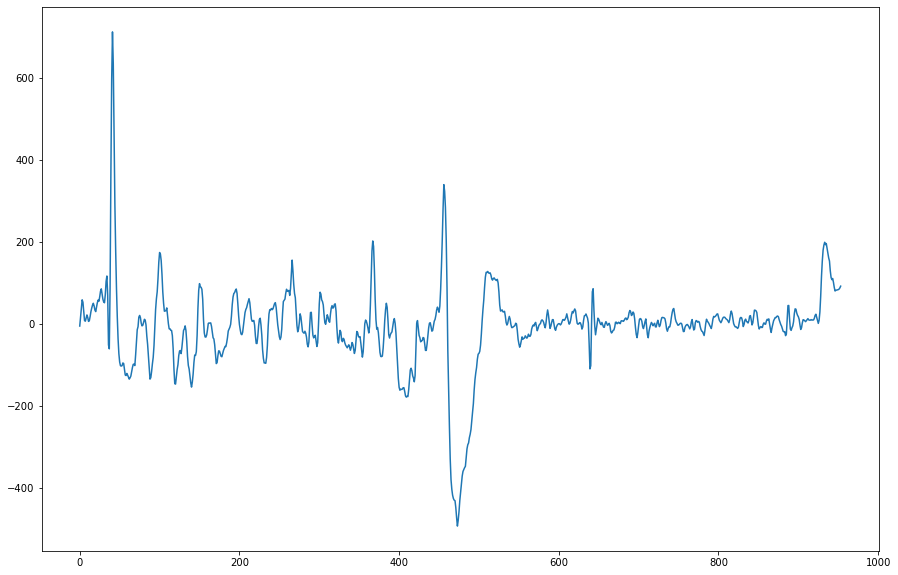

In [143]:
from scipy.signal import savgol_filter

smoothed_2dg = savgol_filter(ADEGREEV, window_length = 5, polyorder = 2)
plt.plot(smoothed_2dg)

In [20]:
# if you want to save the data in excel file use this cell and put variable name inside of the first parentheses
pd.DataFrame(rec).to_excel(r'C:\Users\shumalys\Python\ML\Chirag\DetectedImages.xlsx')